Transparency Removed Image:


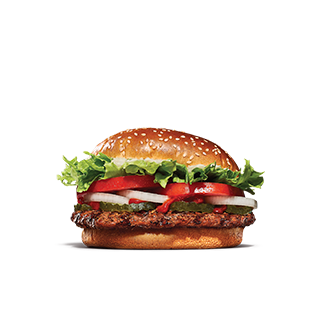

RGB
Mask Image:


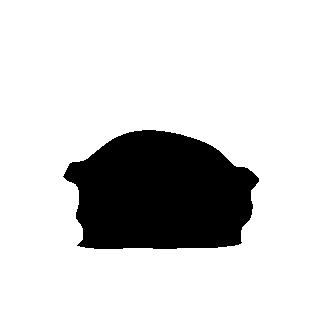

INFO:__main__:Generating image with Amazon Nova Canvas model amazon.nova-canvas-v1:0
INFO:__main__:Successfully generated image with Amazon Nova Canvas model amazon.nova-canvas-v1:0


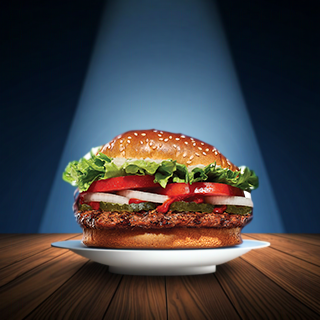

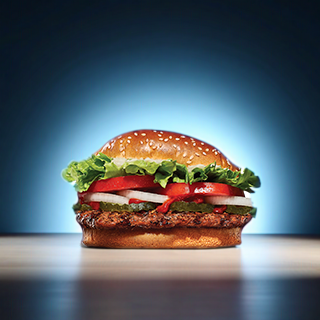

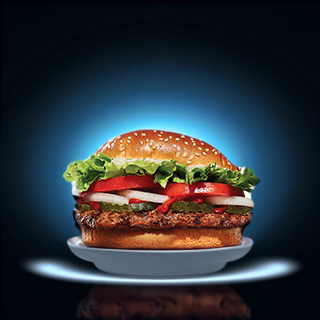

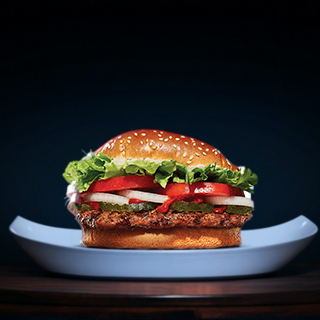

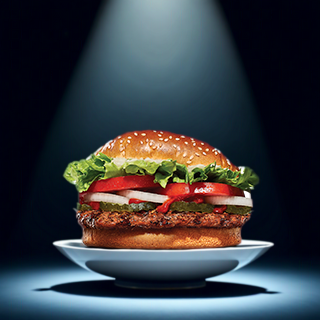

Finished generating image with Amazon Nova Canvas  model amazon.nova-canvas-v1:0.


In [2]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to use outpainting to generate an image from a source image with 
the Amazon Nova Canvas  model (on demand).
The example uses a mask image to outpaint the original image.
"""
import base64
import io
import json
import logging
import boto3
from PIL import Image, ImageFilter
from botocore.config import Config

from botocore.exceptions import ClientError


class ImageError(Exception):
    "Custom exception for errors returned by Amazon Nova Canvas"

    def __init__(self, message):
        self.message = message


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def generate_image(model_id, body):
    """
    Generate an image using Amazon Nova Canvas  model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info(
        "Generating image with Amazon Nova Canvas model %s", model_id)

    bedrock = boto3.client(
        service_name='bedrock-runtime',
        config=Config(read_timeout=300)
    )

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())

    logger.info(
        "Successfully generated image with Amazon Nova Canvas model %s", model_id)

    return response_body


def main():
    """
    Entrypoint for Amazon Nova Canvas  example.
    """
    try:
        logging.basicConfig(level=logging.INFO,
                            format="%(levelname)s: %(message)s")

        model_id = 'amazon.nova-canvas-v1:0'

        # Read image and mask image from file and encode as base64 strings.
        # 이미지 열기 및 투명도 제거
        img = Image.open("./images/whopper.png")
        
        # RGBA에서 RGB로 변환 (투명도 제거)
        if img.mode in ('RGBA', 'LA'):
            background = Image.new('RGB', img.size, (255, 255, 255))  # 흰색 배경
            background.paste(img, mask=img.split()[-1])  # 알파 채널을 마스크로 사용
            img = background

        # 원하는 새 크기 설정
        new_width = 320
        new_height = 320
        
        # 새로운 빈 이미지 생성 (흰색 배경)
        new_img = Image.new('RGB', (new_width, new_height), (255, 255, 255))
        
        # 원본 이미지를 중앙에 배치
        x_offset = (new_width - img.width) // 2
        y_offset = (new_height - img.height) // 2
        new_img.paste(img, (x_offset, y_offset))
        
        # 원본 이미지 대체
        img = new_img

        # 투명도 제거된 이미지 표시
        print("Transparency Removed Image:")
        img.show()

        print(img.mode)

        # 마스크 이미지 생성
        if img.mode == 'RGB':
            alpha = img.split()[-1]
            mask = Image.new('L', img.size, 255)  # L mode = grayscale
            
            for y in range(img.height):
                for x in range(img.width):
                    pixel = img.getpixel((x,y))
                    # RGB 값이 모두 255(흰색)인 경우에만 마스크를 흰색(255)으로 설정
                    if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                        mask.putpixel((x,y), 255)  # 흰색 픽셀은 흰색(255)으로
                    else:
                        mask.putpixel((x,y), 0)    # 그 외는 검은색(0)으로

        # 마스크를 더 거칠게 만들기 위한 처리
        # 1. 가우시안 블러 적용
        mask = mask.filter(ImageFilter.GaussianBlur(radius=5))
        
        # 2. 임계값 처리로 다시 이진화
        for y in range(mask.height):
            for x in range(mask.width):
                pixel = mask.getpixel((x,y))
                if pixel > 127:
                    mask.putpixel((x,y), 255)
                else:
                    mask.putpixel((x,y), 0)
        
        # 3. 팽창 연산 적용
        mask = mask.filter(ImageFilter.MaxFilter(size=7))

        # 마스크 이미지 표시
        print("Mask Image:")
        mask.show()
        
        # 원본 이미지를 base64로 인코딩
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        input_image = base64.b64encode(img_byte_arr).decode('utf8')
        
        # 마스크 이미지를 base64로 인코딩
        mask_byte_arr = io.BytesIO()
        mask.save(mask_byte_arr, format='PNG')
        mask_byte_arr = mask_byte_arr.getvalue()
        input_mask_image = base64.b64encode(mask_byte_arr).decode('utf8')

        body = json.dumps({
            "taskType": "OUTPAINTING",
            "outPaintingParams": {
                "text": "Empty professional studio background only, premium solid wood table surface, dramatic spotlight on dark moody background, cinematic studio lighting, elegant commercial photography setup, soft gradient backdrop, clean minimalist environment",
                "negativeText": "burger, food, dishes, plates, snacks, drinks, ingredients, cooking items, busy patterns, messy background, utensils, text, logos, people, hands, cluttered counters, dirty surfaces, harsh lighting, strong colors, any objects",
                "image": input_image,
                "maskImage": input_mask_image,
                "outPaintingMode": "PRECISE"
            },
            "imageGenerationConfig": {
                "numberOfImages": 5,
                "height": 720,
                "width": 1280,
                "cfgScale": 10
            }
        })

        response_body = generate_image(model_id=model_id,
                                     body=body)
        images = response_body.get("images")  # 생성된 이미지 리스트 가져오기

        # 각 이미지 표시 및 저장
        for i, base64_image in enumerate(images):
            base64_bytes = base64_image.encode('ascii')
            image_bytes = base64.b64decode(base64_bytes)
            image = Image.open(io.BytesIO(image_bytes))
            image.show()  # 이미지 표시
            image.save(f"outpaint_result_{i+1}.png")  # 각 이미지 저장

    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
        print("A client error occured: " +
              format(message))
    except ImageError as err:
        logger.error(err.message)
        print(err.message)

    else:
        print(
            f"Finished generating image with Amazon Nova Canvas  model {model_id}.")

if __name__ == "__main__":
    main()

Transparency Removed Image:


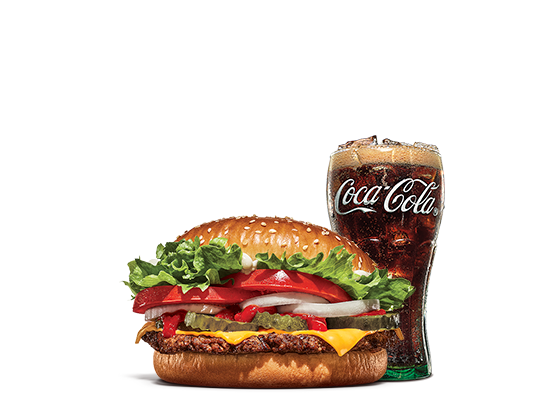

RGB
Mask Image:


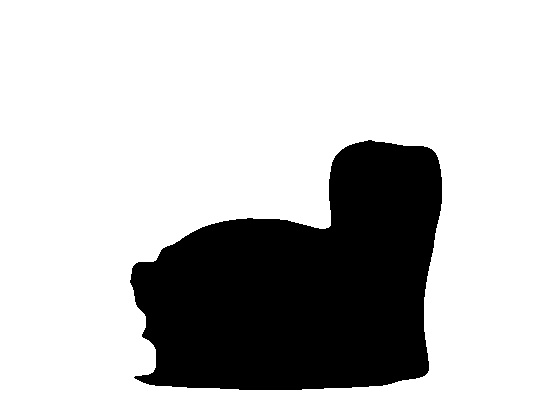

INFO:__main__:Generating image with Amazon Nova Canvas model amazon.nova-canvas-v1:0
INFO:__main__:Successfully generated image with Amazon Nova Canvas model amazon.nova-canvas-v1:0


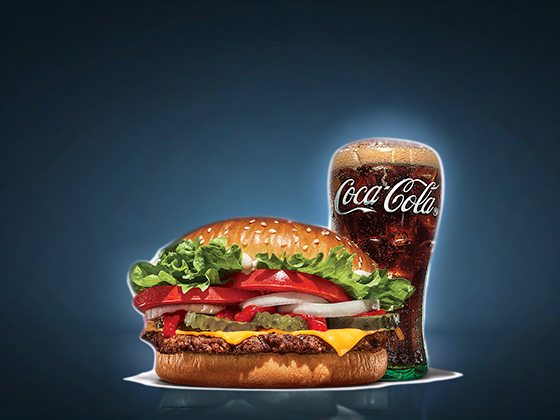

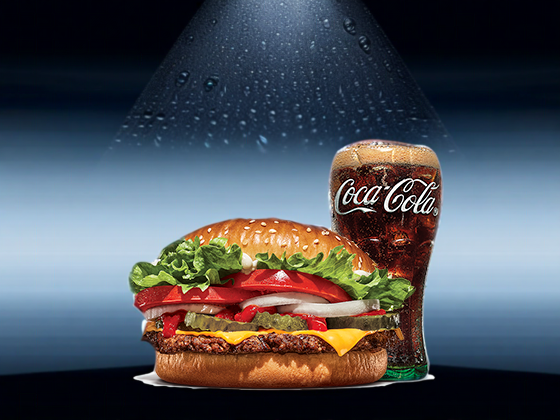

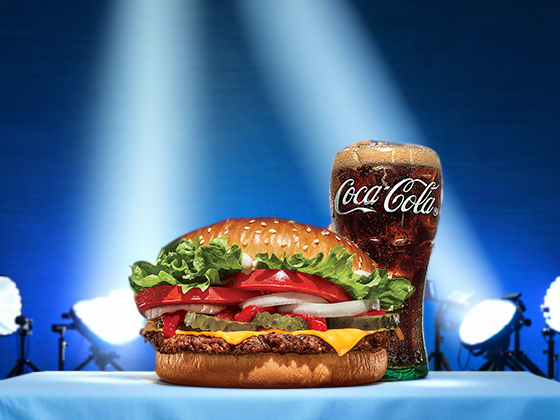

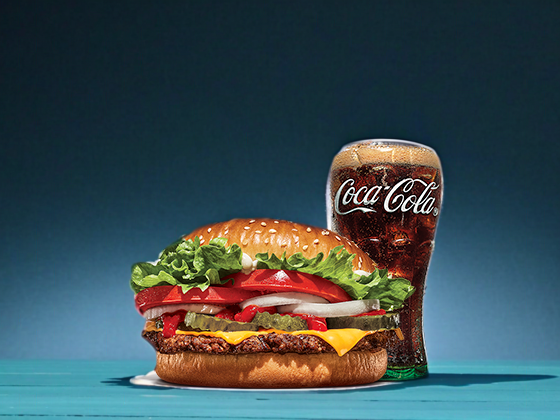

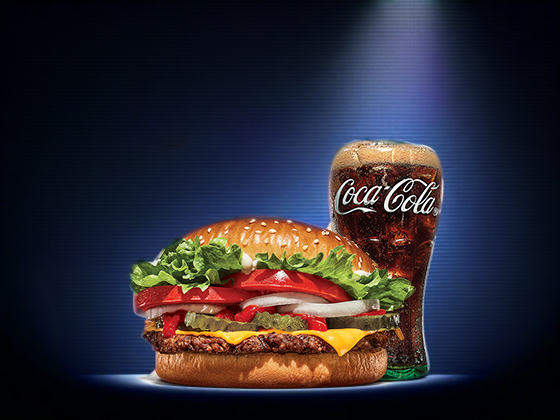

Finished generating image with Amazon Nova Canvas  model amazon.nova-canvas-v1:0.


In [3]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to use outpainting to generate an image from a source image with 
the Amazon Nova Canvas  model (on demand).
The example uses a mask image to outpaint the original image.
"""
import base64
import io
import json
import logging
import boto3
from PIL import Image, ImageFilter
from botocore.config import Config

from botocore.exceptions import ClientError


class ImageError(Exception):
    "Custom exception for errors returned by Amazon Nova Canvas"

    def __init__(self, message):
        self.message = message


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def generate_image(model_id, body):
    """
    Generate an image using Amazon Nova Canvas  model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info(
        "Generating image with Amazon Nova Canvas model %s", model_id)

    bedrock = boto3.client(
        service_name='bedrock-runtime',
        config=Config(read_timeout=300)
    )

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())

    logger.info(
        "Successfully generated image with Amazon Nova Canvas model %s", model_id)

    return response_body


def main():
    """
    Entrypoint for Amazon Nova Canvas  example.
    """
    try:
        logging.basicConfig(level=logging.INFO,
                            format="%(levelname)s: %(message)s")

        model_id = 'amazon.nova-canvas-v1:0'

        # Read image and mask image from file and encode as base64 strings.
        # 이미지 열기 및 투명도 제거
        img = Image.open("./images/whopperandcoke.png")
        
        # RGBA에서 RGB로 변환 (투명도 제거)
        if img.mode in ('RGBA', 'LA'):
            background = Image.new('RGB', img.size, (255, 255, 255))  # 흰색 배경
            background.paste(img, mask=img.split()[-1])  # 알파 채널을 마스크로 사용
            img = background

        # 투명도 제거된 이미지 표시
        print("Transparency Removed Image:")
        img.show()

        print(img.mode)

        # 마스크 이미지 생성
        if img.mode == 'RGB':
            alpha = img.split()[-1]
            mask = Image.new('L', img.size, 255)  # L mode = grayscale
            
            for y in range(img.height):
                for x in range(img.width):
                    pixel = img.getpixel((x,y))
                    # RGB 값이 모두 255(흰색)인 경우에만 마스크를 흰색(255)으로 설정
                    if pixel[0] == 255 and pixel[1] == 255 and pixel[2] == 255:
                        mask.putpixel((x,y), 255)  # 흰색 픽셀은 흰색(255)으로
                    else:
                        mask.putpixel((x,y), 0)    # 그 외는 검은색(0)으로

        # 마스크를 더 거칠게 만들기 위한 처리
        # 1. 가우시안 블러 적용
        mask = mask.filter(ImageFilter.GaussianBlur(radius=5))
        
        # 2. 임계값 처리로 다시 이진화
        for y in range(mask.height):
            for x in range(mask.width):
                pixel = mask.getpixel((x,y))
                if pixel > 127:
                    mask.putpixel((x,y), 255)
                else:
                    mask.putpixel((x,y), 0)
        
        # 3. 팽창 연산 적용
        mask = mask.filter(ImageFilter.MaxFilter(size=7))

        # 마스크 이미지 표시
        print("Mask Image:")
        mask.show()
        
        # 원본 이미지를 base64로 인코딩
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        input_image = base64.b64encode(img_byte_arr).decode('utf8')
        
        # 마스크 이미지를 base64로 인코딩
        mask_byte_arr = io.BytesIO()
        mask.save(mask_byte_arr, format='PNG')
        mask_byte_arr = mask_byte_arr.getvalue()
        input_mask_image = base64.b64encode(mask_byte_arr).decode('utf8')

        body = json.dumps({
            "taskType": "OUTPAINTING",
            "outPaintingParams": {
                "text": "Empty professional studio background only, premium solid wood table surface, dramatic spotlight on dark moody background, cinematic studio lighting, elegant commercial photography setup, soft gradient backdrop, clean minimalist environment",
                "negativeText": "burger, food, dishes, plates, snacks, drinks, ingredients, cooking items, busy patterns, messy background, utensils, text, logos, people, hands, cluttered counters, dirty surfaces, harsh lighting, strong colors, any objects",
                "image": input_image,
                "maskImage": input_mask_image,
                "outPaintingMode": "PRECISE"
            },
            "imageGenerationConfig": {
                "numberOfImages": 5,
                "height": 720,
                "width": 1280,
                "cfgScale": 10
            }
        })

        response_body = generate_image(model_id=model_id,
                                     body=body)
        images = response_body.get("images")  # 생성된 이미지 리스트 가져오기

        # 각 이미지 표시 및 저장
        for i, base64_image in enumerate(images):
            base64_bytes = base64_image.encode('ascii')
            image_bytes = base64.b64decode(base64_bytes)
            image = Image.open(io.BytesIO(image_bytes))
            image.show()  # 이미지 표시
            image.save(f"outpaint_coke_result_{i+1}.png")  # 각 이미지 저장

    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
        print("A client error occured: " +
              format(message))
    except ImageError as err:
        logger.error(err.message)
        print(err.message)

    else:
        print(
            f"Finished generating image with Amazon Nova Canvas  model {model_id}.")

if __name__ == "__main__":
    main()